# ML et prédiction de la qualité du traffic

## 1. Import des packages principaux

In [81]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

import shap

Méthode pour ordonner les colonnes dans un sens donné.

In [82]:
def order_df(df):
    df = df[['month', 'day', 'DEV', 'DEVP', 'GARE', 'HC', 'HL', 'HLP', 'HLPR',
       'HLPS', 'HS', 'INC', 'LIGN', 'TARR', 'TDEP',
       'A - Remplacement Tram par Bus', 'ARDENNE <> ROSERAIE',
       'BEAUCOUZE <> ST BARTHELEMY', 'BELLE BEILLE <> MONPLAISIR',
       'BELLE BEILLE EXPRESS <> GARES', 'BOUCHEMAINE <> Z I  EST',
       'BRIOLLAY <> GARE', 'CIRCULAIRE VERNEAU GARE EUROPE', 'CORNE <> GARE',
       'CORNE <> GARE TRELAZE', 'D NAVETTE MARCHE MONPLAISIR',
       'DJF  BELLE BEILLE <> MONPLAISIR', 'DJF  TRELAZE <>  ST SYLVAIN',
       'DJF LORRAINE <> ST BARTHELEMY', 'DJF MURS ERIGNE <> MONPLAISIR',
       'DJF VILLAGE SANTE <> LORRAINE', 'ECOUFLANT GRIMORELLE <> GARE',
       'ECUILLE SOULAIRE <> GARE', 'ESPACE ANJOU <> EVENTARD',
       'EXPRESS CHANTOURTEAU <> GARES', 'EXPRESS MONTREUIL <> GARES',
       'FENEU CANTENAY <> GARE', 'HOPITAL <> MONTREUIL JUIGNE',
       'LA MEMBROLLE <> GARE', 'LAC MAINE <> STE GEMMES CL ANJOU',
       'M-MARCILLE <> ST AUBIN LA SALLE', 'MURS ERIGNE <> ADEZIERE SALETTE',
       'PLESSIS MACE MEIGNANNE <> GARE', 'PONTS CE <>  AQUAVITA H. RECULEE',
       'SARRIGNE PLESSIS <> GARE', 'SAVENNIERES <> GARE', 'SERVICE NUIT',
       'SOIR LAC MAINE <> CITE CHABADA', 'SOIR LORRAINE <> ST BARTH VERDUN',
       'SOIR MAIRIE PONTS CE <> AVRILLE', 'SOIR TRELAZE <>  LORRAINE',
       'SOUCELLES PELLOUAILLES <> GARE', 'SOULAINES <> GARE',
       'ST CLEMENT St LAMBERT <> GARE', 'ST LEGER St LAMBERT <> GARE',
       'ST LEZIN SORGES <> SCHWEITZER', 'ST MARTIN St JEAN <> GARE',
       'ST MATHURIN <> GARE', 'ST SYLVAIN BANCHAIS <>TRELAZE', 'jour_semaine_Jeudi', 'jour_semaine_Lundi',
       'jour_semaine_Mardi', 'jour_semaine_Mercredi', 'jour_semaine_Samedi',
       'jour_semaine_Vendredi', 'OPINION_météo défavorable',
       'OPINION_météo favorable', 'OPINION_météo idéale',
       'OPINION_météo très défavorable']]
    return df

### 2 Import des données à partir de notre base consolidé

In [83]:
df = pd.read_csv('bus_trafic_clean.csv')

On sélectionne les données qui ont un sens pour la prédiction du retard. 

Dans un premier temps il nous faut une variable qui va définir la qualité du traffic, dans notre cas nous avons décidé de prendre la variable ecart_horaire_en_seconde. En effet, s'il on prend la somme des écarts horaires sur une journée, on peut estimer si cette dernière va être considérée comme une bonne ou mauvaise journée en terme de retard.

Pour réaliser une étude du traffic toutes les variables présentées précédement ne sont pas 'utiles', de ce fait nous allons créer une base d'entrainement avec les variables qui nous semblent pertinentes et les regrouper par jour.

Les paramètres qui nous semblent importants sont : l'écart horaires, l'états des véhicules, les différentes lignes, la date (day, month, jour_semaine) et l'opinion météorologique

L'idée est de regrouper ses informations par jour, cela implique que les écarts vont être sommés et qu'on va dénombrer par jour le nombre de bus/trams par états et le nombre de bus/tram par ligne

L'ambition est d'avoir un jeu composé uniquement de valeurs numériques on va 'dummies' les variables jour_semaine & OPINION.

De plus, l'idée étant de prédire les valeurs la veille pour le lendemain, on va shift nos données de 1 (par date) pour avoir entrainer un modèle sur les valeurs de la veille. De ce fait, en utilisant les valeurs de la veille, on peut prédire le retard du lendemain

In [84]:
df_pred = df[['ecart_horaire_en_secondes', 
            'etat_SAE_du_vehicule', 
            'nom_de_la_ligne', 
            'identifiant_du_vehicule',
            'date',
            'month', 
            'day', 
            'hours', 
            'jour_semaine', 
            'OPINION'
            ]]

print(df_pred.shape)

(739410, 10)


In [1]:
df_date = df_pred[['date', 'month', 'day', 'jour_semaine', 'OPINION']].drop_duplicates()
#display(df_date)

df_etat_SAE_du_vehicule = df_pred[['date', 'etat_SAE_du_vehicule', 'identifiant_du_vehicule']].drop_duplicates()
df_etat_SAE_du_vehicule["count"] = 1
df_etat_SAE_du_vehicule = df_etat_SAE_du_vehicule.groupby(['date', 'etat_SAE_du_vehicule']).sum().reset_index().drop(columns=['identifiant_du_vehicule'])
df_etat_SAE_du_vehicule = df_etat_SAE_du_vehicule.pivot(index='date', columns='etat_SAE_du_vehicule', values='count').reset_index().fillna(0)
#display(df_etat_SAE_du_vehicule)

df_nom_de_la_ligne = df_pred[['date', 'nom_de_la_ligne', 'identifiant_du_vehicule']].drop_duplicates()
df_nom_de_la_ligne["count"] = 1
df_nom_de_la_ligne = df_nom_de_la_ligne.groupby(['date', 'nom_de_la_ligne']).sum().reset_index().drop(columns=['identifiant_du_vehicule'])
df_nom_de_la_ligne = df_nom_de_la_ligne.pivot(index='date', columns='nom_de_la_ligne', values='count').reset_index().fillna(0)
#display(df_nom_de_la_ligne)

df_ecart = df_pred[['date', 'ecart_horaire_en_secondes']]
df_ecart = df_ecart.groupby(['date']).sum().reset_index()
#display(df_ecart)

df_pred = df_date.merge(df_etat_SAE_du_vehicule, on='date', how='left').merge(df_nom_de_la_ligne, on='date', how='left').merge(df_ecart, on='date', how='left').drop(columns=['date'])

df_pred = pd.get_dummies(df_pred, columns=['jour_semaine', 'OPINION'], drop_first=True)
#display(df_pred)

mask = ~(df_pred.columns.isin(['month','day']))
cols_to_shift = df_pred.columns[mask]
df_pred[cols_to_shift] = df_pred.loc[:,mask].shift(1)
df_pred = df_pred.dropna()
#display(df_pred)

NameError: name 'df_pred' is not defined

On créé un dataframe qui va stocker nos résultats.

In [86]:
df_result = pd.DataFrame(columns=["model", "CV", "R2", "MSE", "MAE", "MAPE", "Temps d'execution"])

On met en place un scale de nos données, pour que les données soient dans la même plage de valeurs.

Pour réutiliser le modèle, on entraine le scaler sur le jeu d'entrainement et on split le dataset.

In [87]:
scalerx = StandardScaler()

X = df_pred.drop(columns=['ecart_horaire_en_secondes'])
y = df_pred['ecart_horaire_en_secondes']
y = np.array(y).reshape(-1,1)

scalerx.fit(X)
X = scalerx.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Prédiction par la moyenne

In [88]:
# predict par la moyenne
time_start = time.time()
y_pred = pd.Series([y_train.mean()] * len(y_test))

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["predict means", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

R2:  -0.10851201906727792
MSE:  294442816424.5577
MAE:  477443.30731150036
MAPE:  742.1691267370305


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


#### Régression Linéaire

In [89]:
time_start = time.time()

lr= LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["lr", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

R2:  0.35587326398814134
MSE:  171092858736.22852
MAE:  252093.82227796808
MAPE:  1269.6973770161437


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


#### Modèle de Régression Ridge

In [91]:
time_start = time.time()

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["ridge", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

R2:  0.7781923927780836
MSE:  58916507400.403145
MAE:  157677.0217800025
MAPE:  481.93178056019855


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
time_start = time.time()

param_grid = {'alpha': [0.1, 1, 10, 100, 1000], 'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
grid = GridSearchCV(Ridge(), param_grid, refit = True, verbose = 3, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["ridge_grid", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

#### Random Forest Regressor

In [93]:
time_start = time.time()

clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["RandomForestRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R2:  0.9214907461835974
MSE:  20853617652.736553
MAE:  102062.67076923078
MAPE:  97.18949131230565


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Export du modèle sous format pickle pour être réutilisé. 

In [94]:
import pickle
Pkl_Filename = "Model_1_full_regressor.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

On analyse l'explicatibilité de notre modèle.

On remarque que certains états sont plus impactants que d'autres (TDEP / LIGN / HLPR) sur les écarts.

On remarque également que certaines lignes influent positivement dans la prédiction des écarts (=BELLE BEILLE EXPRESS <> GARES / ST LEZIN SORGES <> SCHWEITZE). 

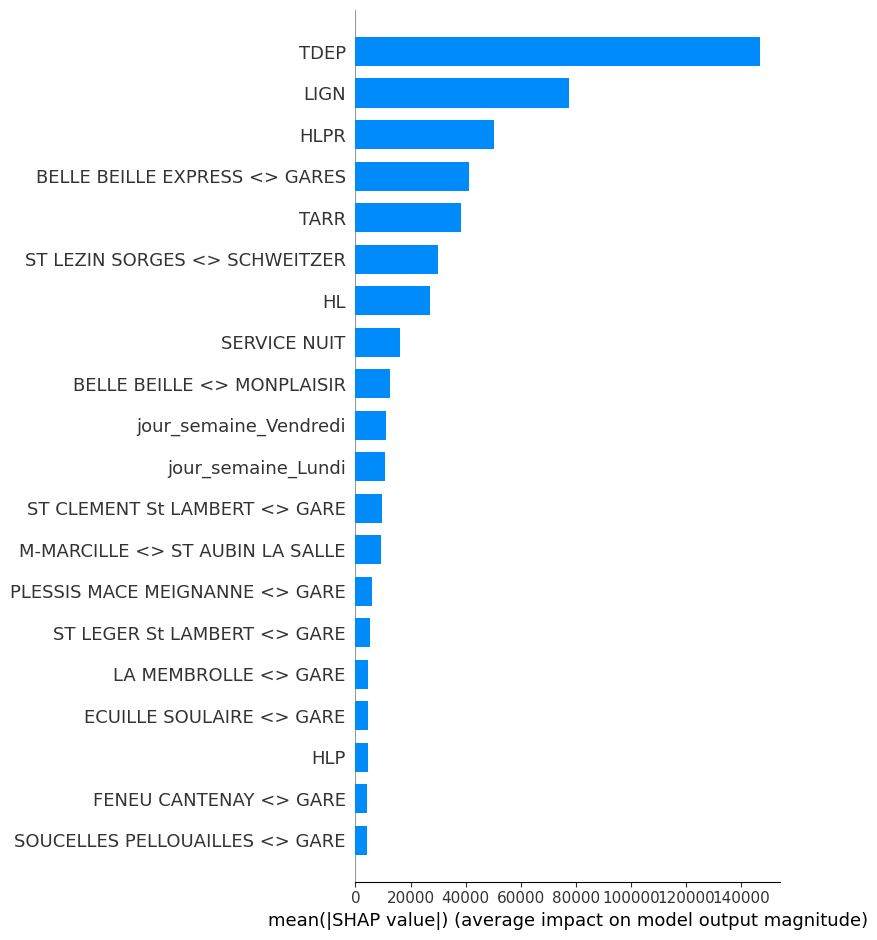

In [95]:
explainer = shap.TreeExplainer(clf)
shap_values = np.array(explainer.shap_values(X_train))
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=df_pred.drop(columns=['ecart_horaire_en_secondes']).columns)


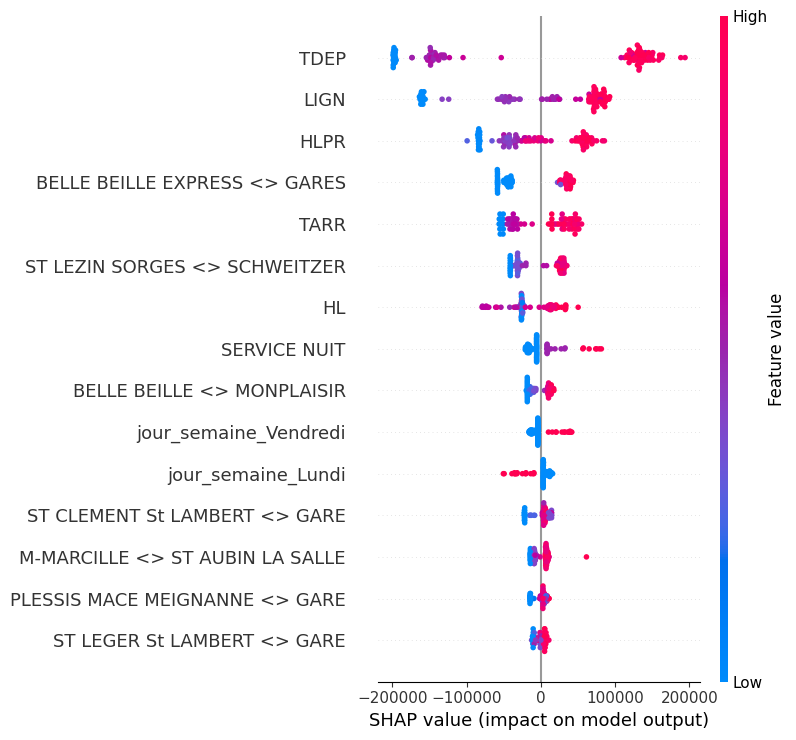

In [96]:
# reduce size feature names
shap.summary_plot(shap_values, X_train, feature_names=df_pred.drop(columns=['ecart_horaire_en_secondes']).columns, max_display=15)

In [98]:
time_start = time.time()

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["RandomForestRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
R2:  0.8982305464841615
MSE:  27031988831.66367
MAE:  121834.30485971527
MAPE:  133.56461465746872


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


#### SGD Regressor

In [99]:
time_start = time.time()

sgdr = SGDRegressor().fit(X_train, y_train)

y_pred = sgdr.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["SGDRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

R2:  0.8722250057830729
MSE:  33939577125.667778
MAE:  118025.89191844557
MAPE:  14.25872053068139


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [100]:
# grid search SGDRegressor
time_start = time.time()

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1, 10, 100]
}

sgdr = SGDRegressor()
grid_search = GridSearchCV(estimator = sgdr, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)
    
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["SGDRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits
R2:  0.8892761471502996
MSE:  29410455202.710262
MAE:  116168.96818658311
MAPE:  5.266556082489794


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


#### MLP Regressor

In [101]:
time_start = time.time()

mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000, random_state=42)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["MLPRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


R2:  0.7350944453591466
MSE:  70364178514.359
MAE:  178581.41002941484
MAPE:  561.4655708587933


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [102]:
time_start = time.time()

param_grid = {'hidden_layer_sizes': [(100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)],
                'max_iter': [1000, 2000, 3000],
                'random_state': [42]}
grid = GridSearchCV(MLPRegressor(), param_grid, refit=True, verbose=3, n_jobs=-1)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["MLPRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


R2:  0.6565376706893435
MSE:  91230418649.91344
MAE:  175726.40287928
MAPE:  883.1712351845321


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [103]:
df_result["Temps d'execution"] = df_result["Temps d'execution"].apply(lambda x: round(x, 2))

# export result to csv
df_result.to_csv("result.csv", index=False)


In [104]:
df_result

,model,CV,R2,MSE,MAE,MAPE,Temps d'execution
0,predict means,false,-0.108512,2.944428e+11,477443.307312,742.169127,0.01
1,lr,false,0.355873,1.710929e+11,252093.822278,1269.697377,0.05
2,lr_grid,true,0.355743,1.711276e+11,252178.561883,1269.697590,0.18
3,ridge,false,0.778192,5.891651e+10,157677.021780,481.931781,0.02
4,ridge_grid,true,0.875518,3.306480e+10,117224.065796,62.263758,0.47
5,RandomForestRegressor,false,0.921491,2.085362e+10,102062.670769,97.189491,0.26
6,RandomForestRegressor,true,0.898231,2.703199e+10,121834.304860,133.564615,158.42
7,SGDRegressor,false,0.872225,3.393958e+10,118025.891918,14.258721,0.02
8,SGDRegressor,true,0.889276,2.941046e+10,116168.968187,5.266556,22.45
9,MLPRegressor,false,0.735094,7.036418e+10,178581.410029,561.465571,2.17
